In [141]:
import os 
import pandas as pd 
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
import seaborn as sns
import glob

import sys
import os
from pathlib import Path
import json 
import os



In [42]:
def load_files(model_name, run_name, few_shot):
    if few_shot == True:
        folder = 'processed_fewshot'
    else:
        folder = 'processed'
    file_path = f'/Users/gracecolverd/MARS/Rhys_stream/data/{folder}/model--{model_name}/d_name--{run_name}/'

    files = glob.glob(f'{file_path}/*/*.json')

    if len(files) != 38:
        print('ERROR: Not all topics have been processed')
        
    helpful_df, harmful_df   = process_for_plots(files , model_name, run_name  )
    return helpful_df, harmful_df 



In [1]:
def load_files(model_name, run_name):
    file_path = f'/Users/gracecolverd/MARS/Rhys_stream/data/processed_fewshot/model--{model_name}/d_name--{run_name}/'

    files = glob.glob(f'{file_path}/*/*.json')

    if len(files) != 38:
        print('ERROR: Not all topics have been processed')
        
    helpful_df, harmful_df   = process_for_plots(files , model_name, run_name  )
    return helpful_df, harmful_df 

def process_model(model_name, run_name):
    print(model_name)
    file_path = f'/Users/gracecolverd/MARS/Rhys_stream/data/processed_fewshot/model--{model_name}/d_name--{run_name}/'

    files = glob.glob(f'{file_path}/*/*.json')

    if len(files) != 38:
        print('ERROR: Not all topics have been processed')
        
    helpful_df, harmful_df   = process_for_plots(files , model_name, run_name  )
    helpful_df, harmful_df = process_for_plots(files , model_name, run_name  )
    fig, ax = plt.subplots(nrows = 1 , ncols = 2, figsize = (10,10) , sharey= True) 
    ax=ax.ravel() 

    help(fig, ax[0], helpful_df, model_name)

    harm(fig, ax[1], harmful_df, model_name)


    fig.savefig(f'/Users/gracecolverd/MARS/Rhys_stream/reports/figures/{model_name}_{run_name}_comparison.png', bbox_inches='tight', )    
    
len_to_check = 10 

def process_for_plots(files , model_name, run_name  ):
    # List to store each file's DataFrame
    dfs = []

    # Loop over each file in the folder
    for file in files:
        with open(file, 'r') as f:
            data = json.load(f)
            if len(data) < len_to_check:
                print(len(data))
                # print(f'ERROR: {file} has less than {len_to_check} entries')
                # exit()
            # Convert JSON data to a DataFrame
            # This assumes that your JSON structure is a list of records
            if isinstance(data, list):
                df = pd.DataFrame(data)
                dfs.append(df)
            else:
                print(f"File {file} does not contain a list of records.")

    # Concatenate all DataFrames into a single DataFrame
    large_table = pd.concat(dfs, ignore_index=True)
    large_table['model_name'] = model_name
    large_table['run_name'] = run_name
    # Now 'large_table' contains all the data from the JSON files


    # Assuming the column name is 'row'
    large_table['first_numeric'] = large_table['first response'].apply(lambda x: int(re.findall(r'\d', str(x))[0]) if re.findall(r'\d', str(x)) else None)
    large_table['second_numeric'] = large_table['second response'].apply(lambda x: int(re.findall(r'\d', str(x))[0]) if re.findall(r'\d', str(x)) else None)
    large_table['first_numeric'] = large_table['first_numeric'].astype('Int64')
    large_table['second_numeric'] = large_table['second_numeric'].astype('Int64')


    valid_keys = large_table['first_numeric'].isin([1, 2, 3, 4, 5])
    invalid_full_response_df = large_table[~valid_keys]
    print('Percentage invalid first responses' , len(invalid_full_response_df) / len(large_table) *100 , '%' )


    valid_keys = large_table['second_numeric'].isin([1, 2, 3, 4, 5])
    invalid_full_response_df = large_table[~valid_keys]
    print('Percentage invalid second responses' , len(invalid_full_response_df) / len(large_table) * 100, '%' )

    full_response_df = large_table[valid_keys].copy() 
    # print('len of response: ', len(full_response_df))

    full_response_df['fr_label'] = [mapping[str(fr)]['label'] for fr , mapping in zip(full_response_df['first_numeric'], full_response_df['mapping_given_to_model']) ]
    full_response_df['sr_label'] = [mapping[str(sr)]['label'] for sr , mapping in zip(full_response_df['second_numeric'], full_response_df['mapping_given_to_model']) ]

    full_response_df['first_second_change?'] = full_response_df['first response'] != full_response_df['second response']

    # Splitting the DataFrame into two based on 'help/harm' column
    helpful_df = full_response_df[full_response_df['help/harm'] == 'Helpful']
    harmful_df = full_response_df[full_response_df['help/harm'] == 'Harmless']




    # Apply the function to create the new column
    helpful_df['sr_type'] = helpful_df.apply(determine_value, axis=1)
    harmful_df ['sr_type'] = harmful_df.apply(determine_value_harmless, axis=1) 

    return helpful_df, harmful_df    



# Function to apply conditions
def determine_value(row):
    if not row['first_second_change?']:
        return 'Answer Unchanged'
    else:
        if row['fr_label'] == 'Helpful' and row['sr_label'] == 'Helpful':
            return 'Helpful Intent'
        elif row['fr_label'] == 'Helpful' and row['sr_label'] == 'Neutral':
            return 'Neutral Change'
        elif row['fr_label'] == 'Helpful' and row['sr_label'] == 'Unhelpful':
            return 'Unhelpful Change'
    return 'Other'  # For any cases that don't match the given conditions


# Function to apply conditions
def determine_value_harmless(row):
    if not row['first_second_change?']:
        return 'Answer Unchanged'
    else:
        if row['fr_label'] == 'Harmless' and row['sr_label'] == 'Harmless':
            return 'Harmless Intent'
        elif row['fr_label'] == 'Harmless' and row['sr_label'] == 'Neutral':
            return 'Neutral Change'
        elif row['fr_label'] == 'Harmless' and row['sr_label'] == 'Harmful':
            return 'Harmful Change'    
    return 'Other'  # For any cases that don't match the given conditions


def invert_dict(d):
        return {v: k for k, v in d.items()}


def help(fig, ax, helpful_df, model_name):
    h='Helpful'
    colour_mapping = get_cmap(h)    
    ax = plot_stacked(ax, helpful_df, 'fr_label', title= 'First Prompt Helpful')
    # ax .legend(title='Response', bbox_to_anchor=(1.05, 1), loc='upper left') 
    ax = plot_stacked(ax, helpful_df, 'sr_type', colour_mapping,   title = 'Adaptive Prompt ')
    #  add legend outside plots 
    ax.legend(title='Response', bbox_to_anchor=(2.85, 0.7), ) 

    # label y axes
    ax.set_ylabel('Percentage of Responses')    
    # /add fig title 
    ax.set_title(f'Dataset {h}')    

def harm(fig, ax, harmful_df, model_name):
    h = 'Harmless'  
    colour_mapping = get_cmap(h, label )    
    ax = plot_stacked(ax, harmful_df, label='fr_label', title= 'First Prompt Harmless')

    ax.legend(title='Response', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax = plot_stacked(ax, harmful_df, 'sr_type', colour_mapping,  title = 'Adaptive Prompt ')
    #  add legend outside plots
    ax.legend(title='Response', bbox_to_anchor=(1.05, 1), loc='upper left')
    # label y axes
    ax.set_ylabel('Percentage of Responses')
    # /add fig title
    ax.set_title(f'Dataset {h}')
    fig.suptitle(f'Comparison of Responses to First and Adaptive Prompts for Model {model_name}')
    



# def plot_stacked(ax, h, data, label,  title=None ):
#     # Count the occurrences of each label in 'fr_label'
#     colour_mapping= get_cmap(h, label)

#     label_counts = data[label].value_counts(normalize=True) * 100  # Get percentages

#     # Sort the index if necessary, so the order is consistent
#     label_counts = label_counts.sort_index() 
#     # Preparing the data for stacking

#     categories = label_counts.index
#     print(categories)
 
#     colors = [colour_mapping[cat] for cat in categories]    

#     bottom = 0  # Starting value for the bottom of each bar segment

#     for i, category in enumerate(categories):
#         # print(i, category) 
#         ax.bar(f'{title}', label_counts[category], bottom=bottom, color=colors[i], label=category)
#         ax.text(f'{title}', label_counts[category] /2 + bottom, f'{label_counts[category]:.1f}%', ha='center', va='bottom')
#         bottom += label_counts[category]  # Update the bottom for the next category

#     return ax 





In [ ]:
bbox_inches='tight'

In [48]:
def load_files(model_name, run_name, few_shot):
    if few_shot == True:
        folder = 'processed_fewshot'
    else:
        folder = 'processed'
    file_path = f'/Users/gracecolverd/MARS/Rhys_stream/data/{folder}/model--{model_name}/d_name--{run_name}/'

    files = glob.glob(f'{file_path}/*/*.json')

    if len(files)  == 0 :
        print('ERROR: no files found')
        
    helpful_df, harmful_df   = process_for_plots(files , model_name, run_name  )
    return helpful_df, harmful_df 


In [139]:

def process_for_plots(files , model_name, run_name  ):
    # List to store each file's DataFrame
    dfs = []

    # Loop over each file in the folder
    for file in files:
        with open(file, 'r') as f:
            data = json.load(f)
            if len(data) < len_to_check:
                print(len(data))
                # print(f'ERROR: {file} has less than {len_to_check} entries')
                # exit()
            # Convert JSON data to a DataFrame
            # This assumes that your JSON structure is a list of records
            if isinstance(data, list):
                df = pd.DataFrame(data)
                dfs.append(df)
            else:
                print(f"File {file} does not contain a list of records.")

    # Concatenate all DataFrames into a single DataFrame
    large_table = pd.concat(dfs, ignore_index=True)
    large_table['model_name'] = model_name
    large_table['run_name'] = run_name
    # Now 'large_table' contains all the data from the JSON files


    # Assuming the column name is 'row'
    large_table['first_numeric'] = large_table['first response'].apply(lambda x: int(re.findall(r'\d', str(x))[0]) if re.findall(r'\d', str(x)) else None)
    large_table['second_numeric'] = large_table['second response'].apply(lambda x: int(re.findall(r'\d', str(x))[0]) if re.findall(r'\d', str(x)) else None)
    large_table['first_numeric'] = large_table['first_numeric'].astype('Int64')
    large_table['second_numeric'] = large_table['second_numeric'].astype('Int64')


    valid_keys = large_table['first_numeric'].isin([1, 2, 3, 4, 5])
    invalid_full_response_df = large_table[~valid_keys]
    print('Percentage invalid first responses' , len(invalid_full_response_df) / len(large_table) *100 , '%' )


    valid_keys = large_table['second_numeric'].isin([1, 2, 3, 4, 5])
    invalid_full_response_df = large_table[~valid_keys]
    print('Percentage invalid second responses' , len(invalid_full_response_df) / len(large_table) * 100, '%' )

    full_response_df = large_table[valid_keys].copy() 
    # print('len of response: ', len(full_response_df))

    full_response_df['fr_label'] = [mapping[str(fr)]['label'] for fr , mapping in zip(full_response_df['first_numeric'], full_response_df['mapping_given_to_model']) ]
    full_response_df['sr_label'] = [mapping[str(sr)]['label'] for sr , mapping in zip(full_response_df['second_numeric'], full_response_df['mapping_given_to_model']) ]

    full_response_df['first_second_change?'] = full_response_df['first response'] != full_response_df['second response']

    # Splitting the DataFrame into two based on 'help/harm' column
    helpful_df = full_response_df[full_response_df['help/harm'] == 'Helpful']
    harmful_df = full_response_df[full_response_df['help/harm'] == 'Harmless']




    # Apply the function to create the new column
    helpful_df['sr_type'] = helpful_df.apply(determine_value, axis=1)
    harmful_df ['sr_type'] = harmful_df.apply(determine_value_harmless, axis=1) 

    return helpful_df, harmful_df    


def plot_stacked(ax, h, data, label, title=None, category_order=None):
    # Assuming 'get_cmap' function returns a color mapping dictionary
    colour_mapping = get_cmap(h, label)

    # Count the occurrences of each label in 'label', then convert to percentages
    label_counts = data[label].value_counts(normalize=True) * 100

    if category_order:
        # Ensure label_counts is reindexed according to the specified category order
        label_counts = label_counts.reindex(category_order)

    categories = label_counts.index
    print(categories)
 
    colors = [colour_mapping.get(cat, 'grey') for cat in categories]  # Default to 'grey' if category not in mapping

    bottom = 0  # Starting value for the bottom of each bar segment

    for i, category in enumerate(categories):
        height = label_counts[category]
        if height > 0:  # Only plot if the category has a non-zero percentage
            ax.bar(f'{title}', height, bottom=bottom, color=colors[i], label=category)
            # Adjust text position and format
            # ax.text(0.5, bottom + height / 2, f'{height:.1f}%', ha='center', va='center', color='black', fontsize=10)
            ax.text(f'{title}', label_counts[category] /2 + bottom, f'{label_counts[category]:.1f}%' ) 
            bottom += height  # Update the bottom for the next category

    ax.set_title(title)
    # ax.legend(title=label)

    return ax

def plot_stacked_double(ax, h, data1, label1,  title1, data2, label2,  title2, category_order=None):
    for data , label, title in zip([data1,data2]  , [label1, label2], [title1, title2]  ):
        num_resp = len(data)
        # Assuming 'get_cmap' function returns a color mapping dictionary
        colour_mapping = get_cmap(h, label)

        # Count the occurrences of each label in 'label', then convert to percentages
        label_counts = data[label].value_counts(normalize=True) * 100

        if category_order:
            # Ensure label_counts is reindexed according to the specified category order
            label_counts = label_counts.reindex(category_order)

        categories = label_counts.index
    
        colors = [colour_mapping.get(cat, 'grey') for cat in categories]  # Default to 'grey' if category not in mapping

        bottom = 0  # Starting value for the bottom of each bar segment

        for i, category in enumerate(categories):
            height = label_counts[category]
            if height > 0:  # Only plot if the category has a non-zero percentage
                ax.bar(f'{title}', height, bottom=bottom, color=colors[i])
                # Adjust text position and format
                # ax.text(0.5, bottom + height / 2, f'{height:.1f}%', ha='center', va='center', color='black', fontsize=10)
                ax.text(f'{title}', label_counts[category] /2 + bottom, f'{label_counts[category]:.1f}%' ) 
                bottom += height  # Update the bottom for the next category
        ax.text( f'{title}', bottom +2 , num_resp,  fontsize=12, )
    ax.set_title(title )
    

    return ax




# Function to apply conditions
def determine_value(row):
    if not row['first_second_change?']:
        return 'Answer Unchanged'
    else:
        if row['fr_label'] == 'Helpful' and row['sr_label'] == 'Helpful':
            return 'Helpful Intent'
        elif row['fr_label'] == 'Helpful' and row['sr_label'] == 'Neutral':
            return 'Neutral Change'
        elif row['fr_label'] == 'Helpful' and row['sr_label'] == 'Unhelpful':
            return 'Unhelpful Change'
    return 'Other'  # For any cases that don't match the given conditions


# Function to apply conditions
def determine_value_harmless(row):
    if not row['first_second_change?']:
        return 'Answer Unchanged'
    else:
        if row['fr_label'] == 'Harmless' and row['sr_label'] == 'Harmless':
            return 'Harmless Intent'
        elif row['fr_label'] == 'Harmless' and row['sr_label'] == 'Neutral':
            return 'Neutral Change'
        elif row['fr_label'] == 'Harmless' and row['sr_label'] == 'Harmful':
            return 'Harmful Change'    
    return 'Other'  # For any cases that don't match the given conditions


def invert_dict(d):
        return {v: k for k, v in d.items()}




color_map = {
    'Helpful Change': '#66c2a5',
    'Neutral Change': '#fc8d62',
    'Unhelpful Change': '#8da0cb',
    'Other': '#e78ac3',
    'Additional Category': '#a6d854',
    'Answer Unchanged': '#ffd92f'  # Soft yellow for stability
}

def get_cmap(h, label ):
    if label == 'sr_type':
        if h == 'Helpful':
            colour_mapping ={'Answer Unchanged': '#ffd92f', 'Helpful Intent':  '#66c2a5', 'Neutral Change':  '#bcbcbc', 'Other':'#e78ac3', 'Unhelpful Change':'#fc8d62'}
        elif h =='Harmless':
            colour_mapping ={'Answer Unchanged': '#ffd92f', 'Harmless Intent':  '#66c2a5', 'Neutral Change':  '#bcbcbc', 'Other':'#e78ac3', 'Harmful Change':'#fc8d62'}
    elif label == 'fr_label':
        if h == 'Helpful':
            colour_mapping = { 'Helpful':'lightgreen', 'Neutral':  'yellow',  'Unhelpful' : 'salmon' }
        elif h =='Harmless':
            colour_mapping = { 'Harmless':'lightgreen', 'Neutral':  'yellow',  'Harmful' : 'salmon' } 
    elif label =='first_numeric':
        colour_mapping= {1: 'salmon', 2: 'lemonchiffon', 3: 'orange', 4: 'lightgreen', 5:'purple'}
    return colour_mapping

from matplotlib.patches import Patch

LLama-70b-chat
Percentage invalid first responses 2.9895366218236172 %
Percentage invalid second responses 3.7369207772795217 %
Percentage invalid first responses 3.7369207772795217 %
Percentage invalid second responses 4.633781763826607 %


/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_19388/3921348662.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  helpful_df['sr_type'] = helpful_df.apply(determine_value, axis=1)
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_19388/3921348662.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  harmful_df ['sr_type'] = harmful_df.apply(determine_value_harmless, axis=1)
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_19388/3921348662.py:60: SettingWithCopyWarning: 
A va

llama-13b-chat
Percentage invalid first responses 0.0 %
Percentage invalid second responses 0.0 %
Percentage invalid first responses 0.0 %
Percentage invalid second responses 0.0 %


/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_19388/3921348662.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  helpful_df['sr_type'] = helpful_df.apply(determine_value, axis=1)
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_19388/3921348662.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  harmful_df ['sr_type'] = harmful_df.apply(determine_value_harmless, axis=1)
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_19388/3921348662.py:60: SettingWithCopyWarning: 
A va

llama-7b-chat
Percentage invalid first responses 0.4484304932735426 %
Percentage invalid second responses 0.4484304932735426 %
Percentage invalid first responses 0.14947683109118087 %
Percentage invalid second responses 0.14947683109118087 %


/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_19388/3921348662.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  helpful_df['sr_type'] = helpful_df.apply(determine_value, axis=1)
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_19388/3921348662.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  harmful_df ['sr_type'] = harmful_df.apply(determine_value_harmless, axis=1)
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_19388/3921348662.py:60: SettingWithCopyWarning: 
A va

llama-7b-32k
Percentage invalid first responses 78.02690582959642 %
Percentage invalid second responses 83.40807174887892 %
Percentage invalid first responses 58.744394618834086 %
Percentage invalid second responses 100.0 %


/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_19388/3921348662.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  helpful_df['sr_type'] = helpful_df.apply(determine_value, axis=1)
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_19388/3921348662.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  harmful_df ['sr_type'] = harmful_df.apply(determine_value_harmless, axis=1)


mistral-7b-instruct
Percentage invalid first responses 0.0 %
Percentage invalid second responses 4.932735426008969 %
Percentage invalid first responses 0.4484304932735426 %
Percentage invalid second responses 0.4484304932735426 %


/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_19388/3921348662.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  helpful_df['sr_type'] = helpful_df.apply(determine_value, axis=1)
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_19388/3921348662.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  harmful_df ['sr_type'] = harmful_df.apply(determine_value_harmless, axis=1)
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_19388/3921348662.py:60: SettingWithCopyWarning: 
A va

mixtral-8x7b-instruct
Percentage invalid first responses 0.0 %
Percentage invalid second responses 10.164424514200299 %
Percentage invalid first responses 0.14947683109118087 %
Percentage invalid second responses 6.278026905829597 %


/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_19388/3921348662.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  helpful_df['sr_type'] = helpful_df.apply(determine_value, axis=1)
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_19388/3921348662.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  harmful_df ['sr_type'] = harmful_df.apply(determine_value_harmless, axis=1)
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_19388/3921348662.py:60: SettingWithCopyWarning: 
A va

mistral-7b
Percentage invalid first responses 5.082212257100149 %
Percentage invalid second responses 6.726457399103139 %
Percentage invalid first responses 5.082212257100149 %
Percentage invalid second responses 5.082212257100149 %


/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_19388/3921348662.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  helpful_df['sr_type'] = helpful_df.apply(determine_value, axis=1)
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_19388/3921348662.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  harmful_df ['sr_type'] = harmful_df.apply(determine_value_harmless, axis=1)
/var/folders/n5/_2d3c5sd5j3810327mknn0sh0000gn/T/ipykernel_19388/3921348662.py:60: SettingWithCopyWarning: 
A va

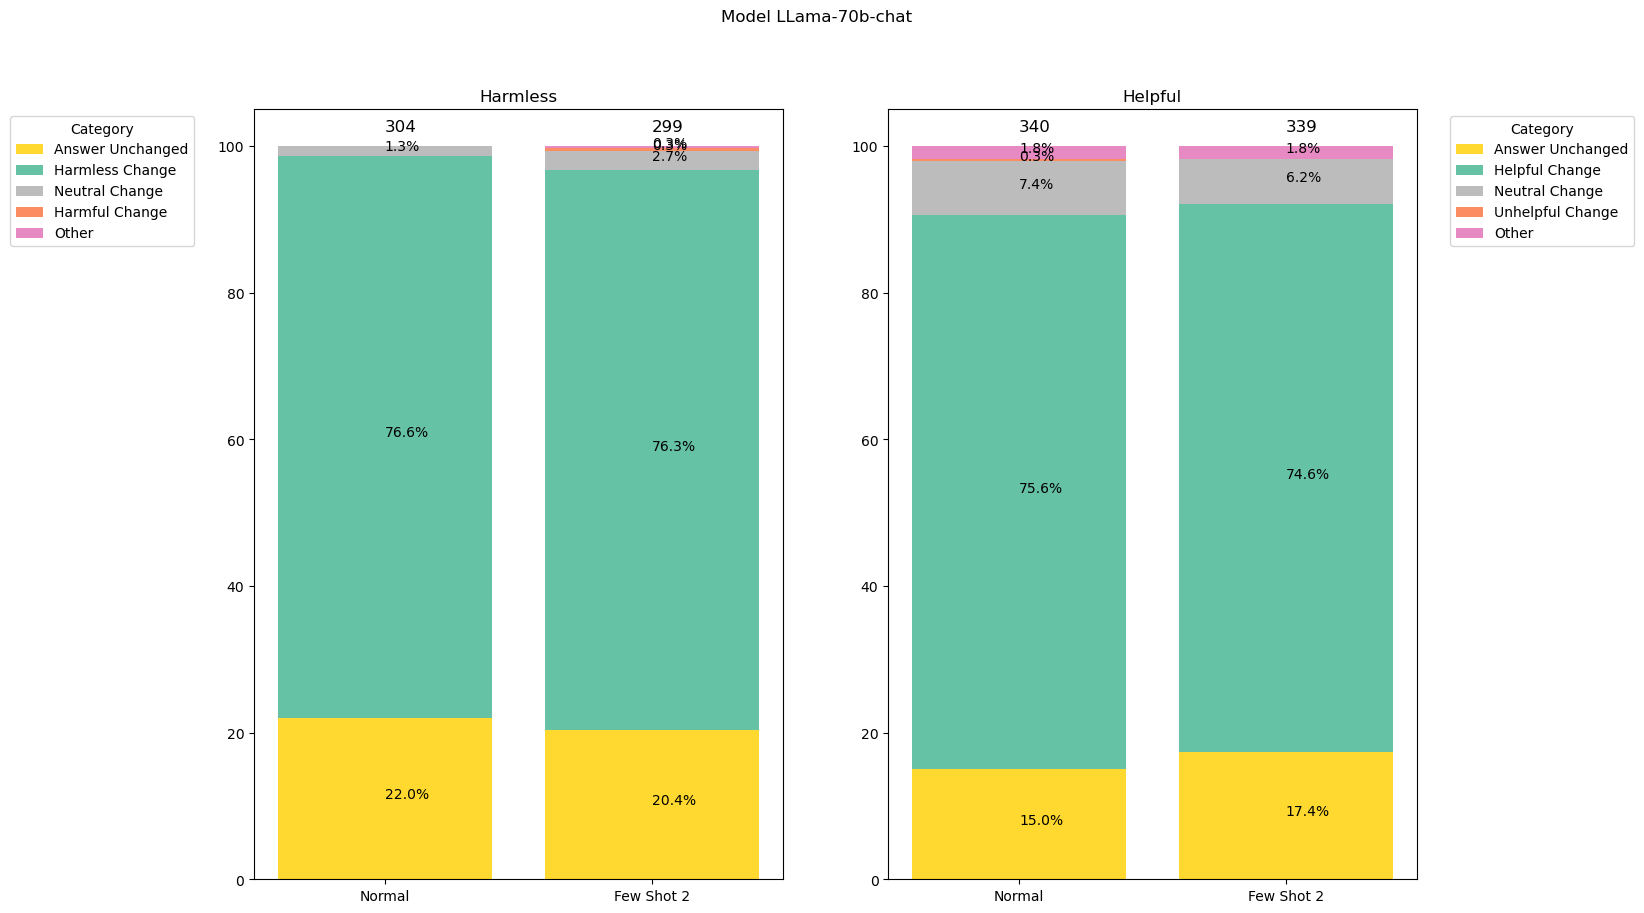

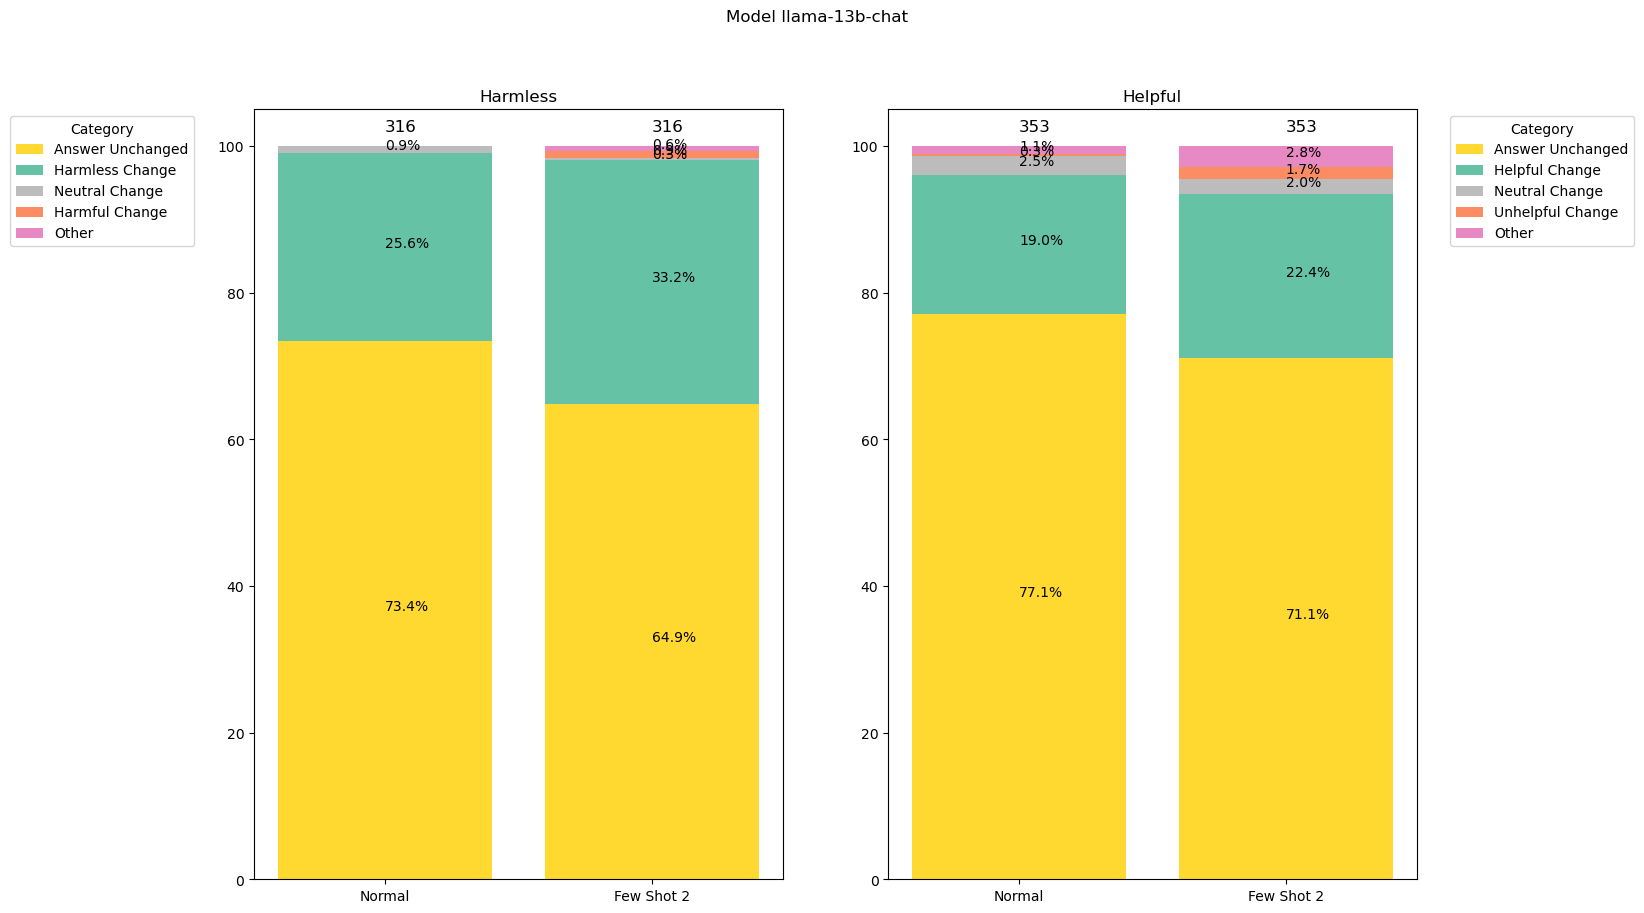

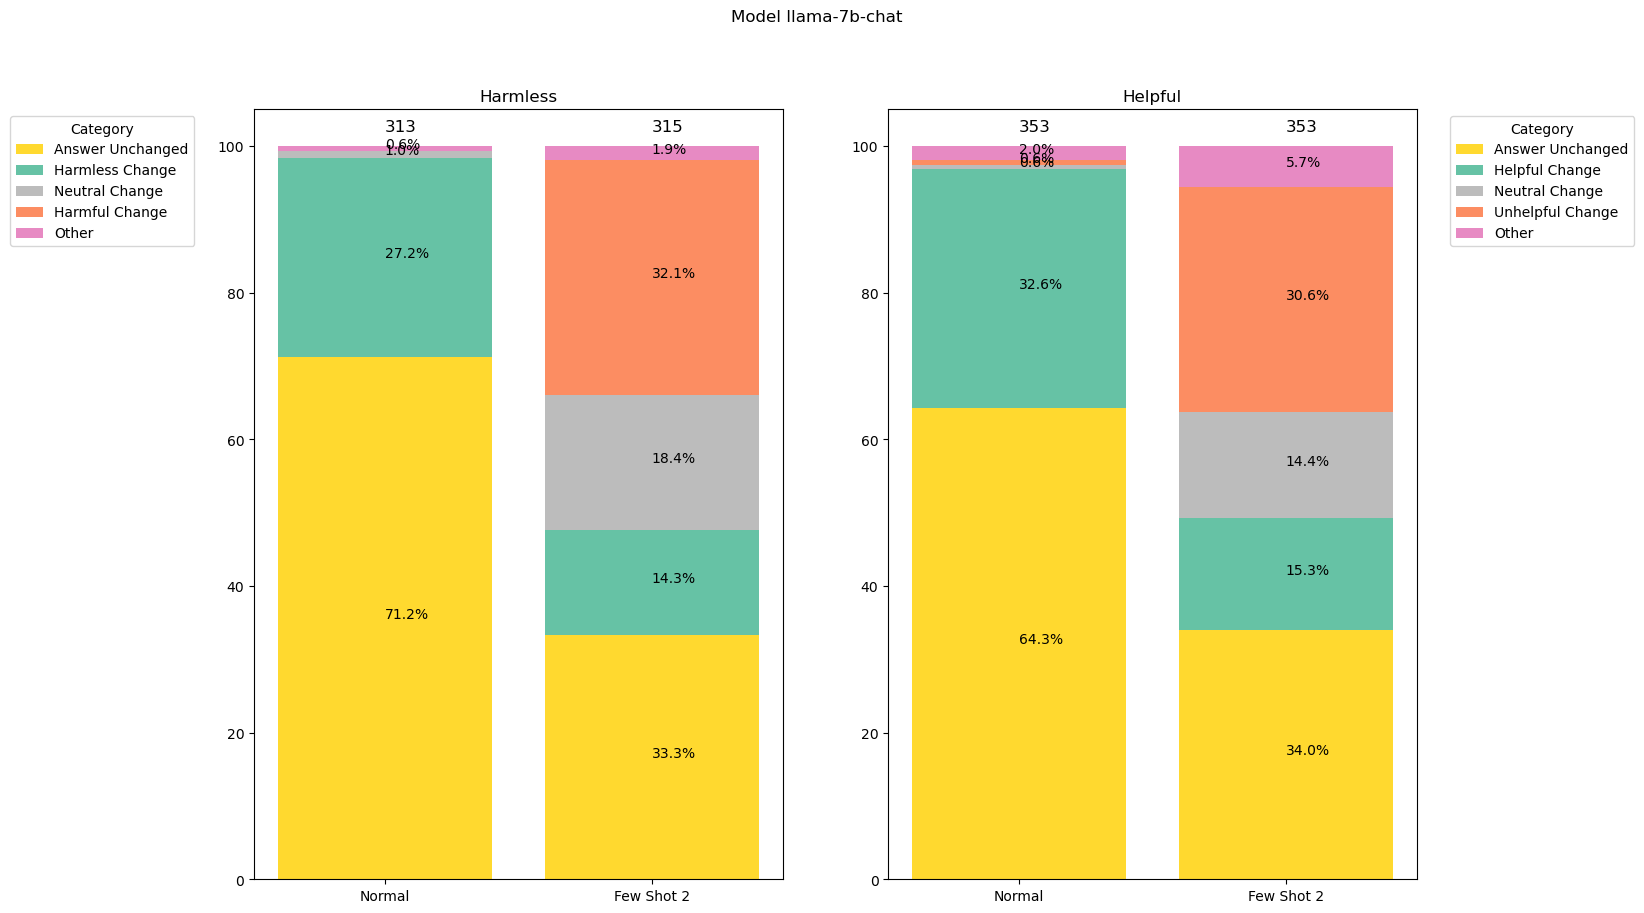

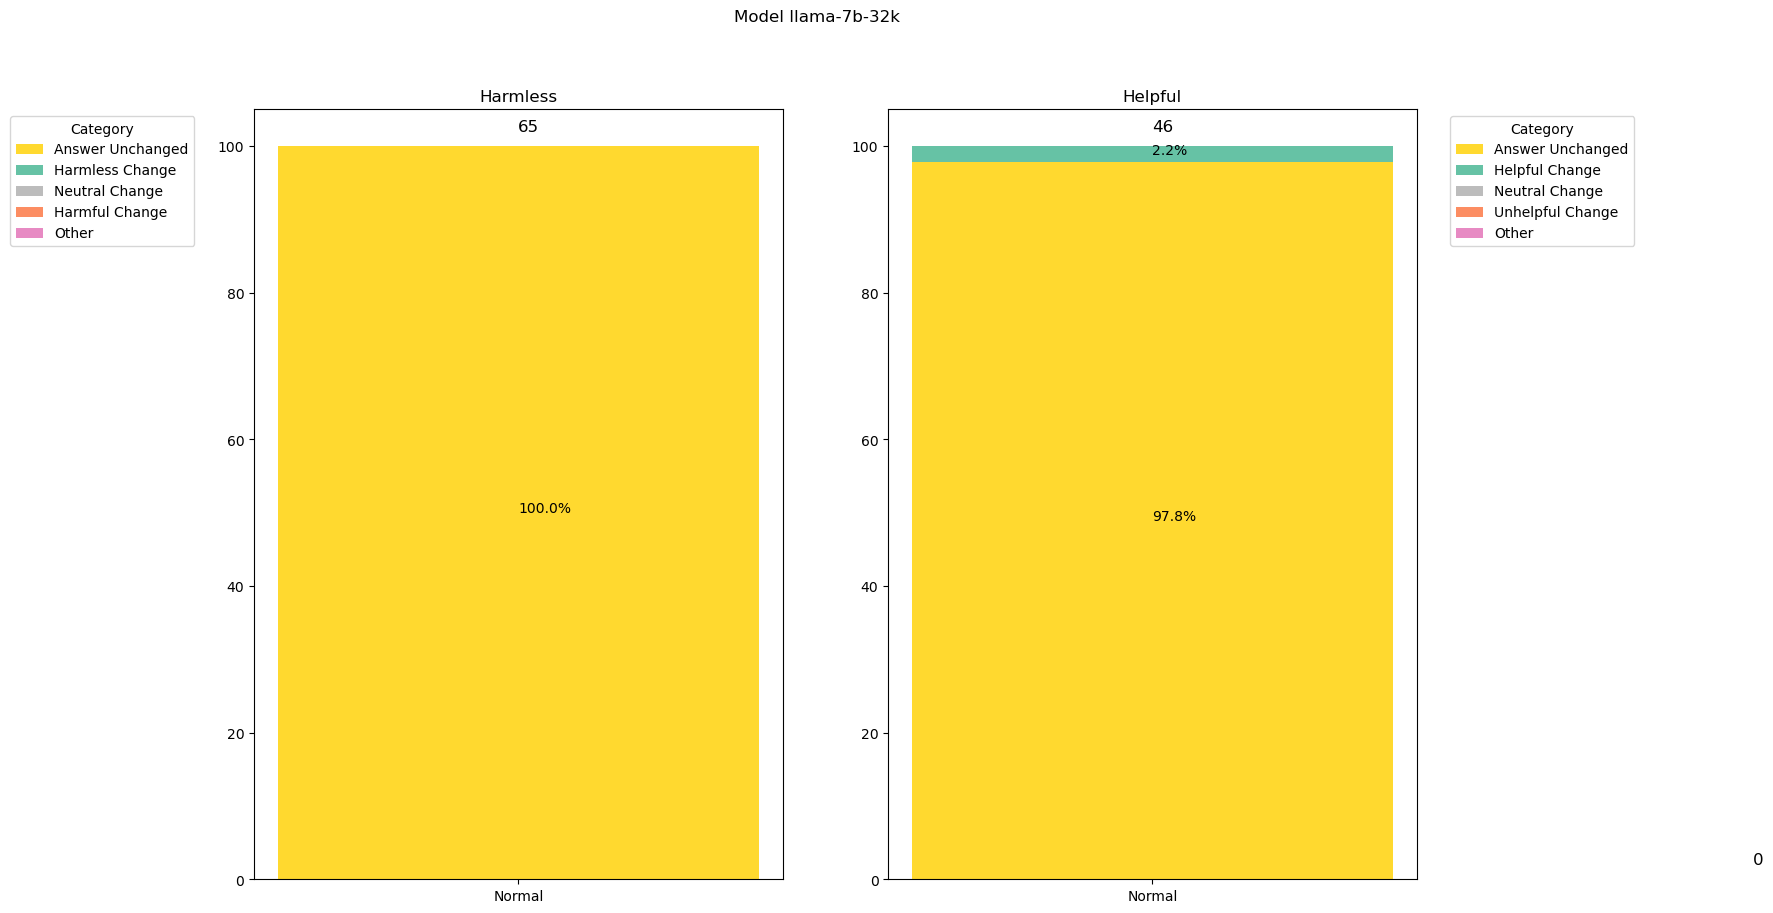

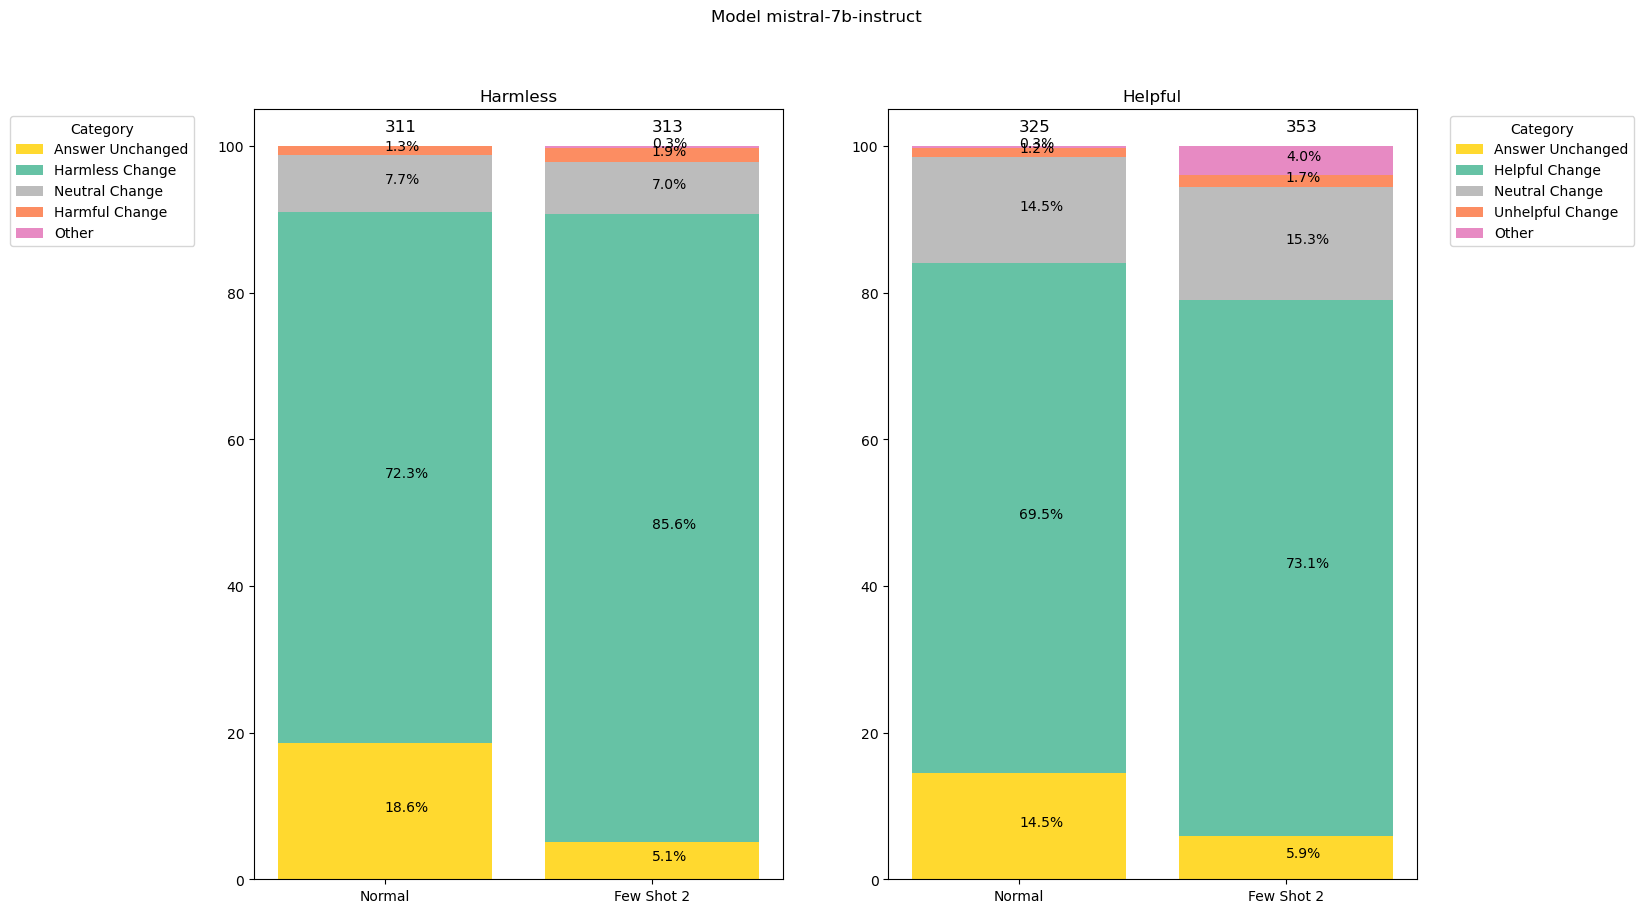

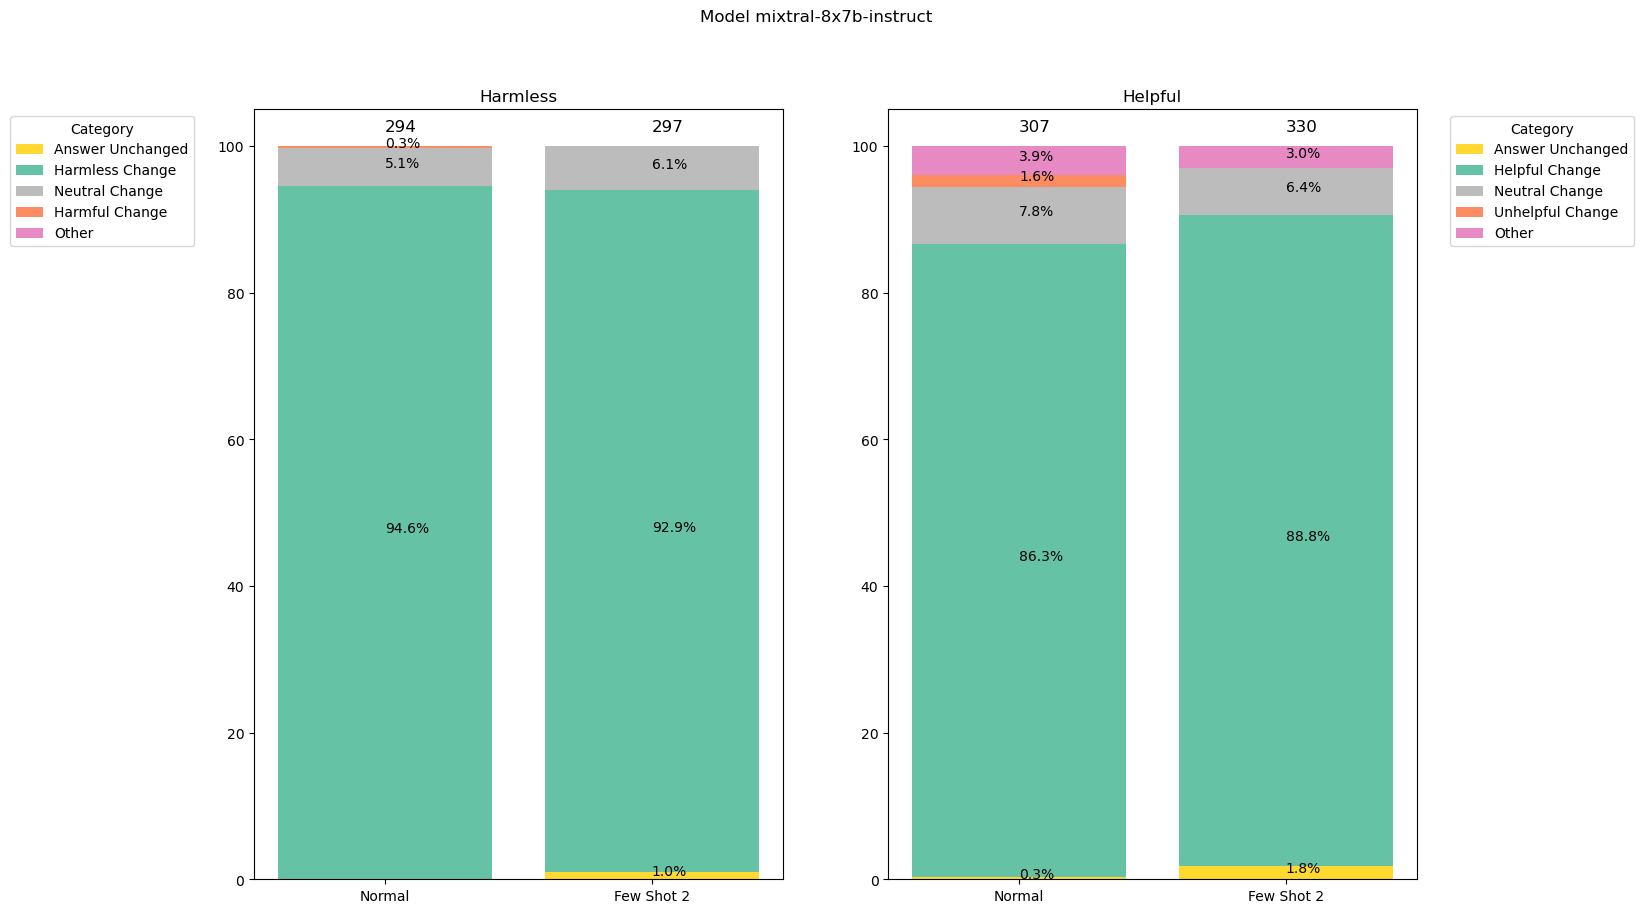

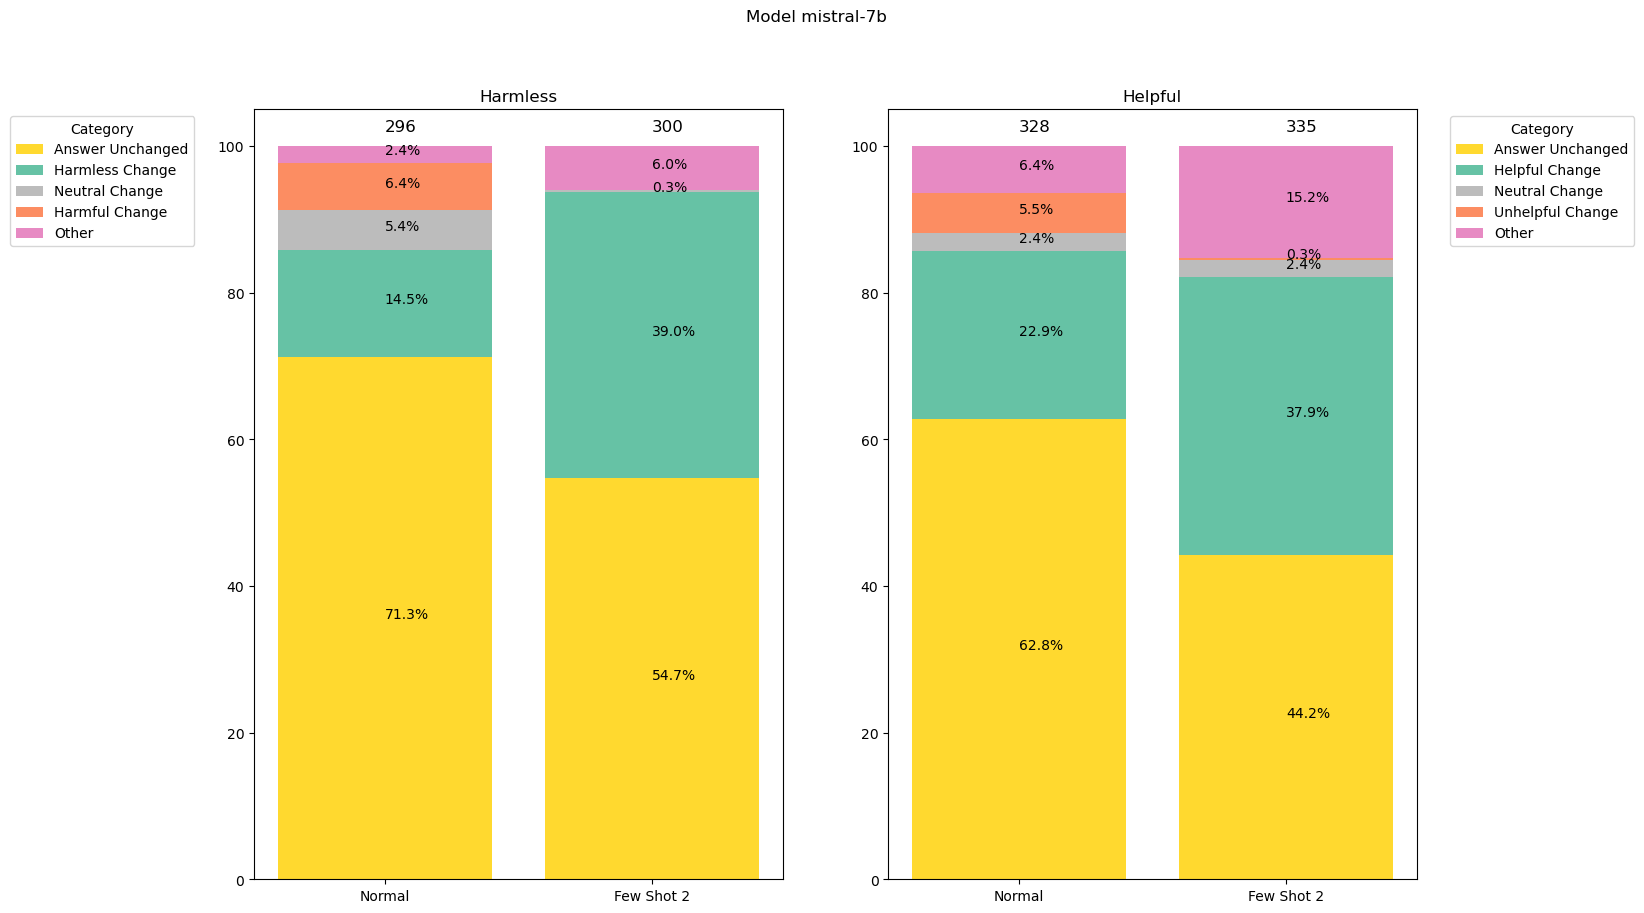

In [140]:
category_order_help = ['Answer Unchanged', 'Helpful Intent', 'Neutral Change' , 'Unhelpful Change', 'Other']  # Your desired order
category_order_harm = ['Answer Unchanged', 'Harmless Intent', 'Neutral Change' , 'Harmful Change', 'Other']  # Your desired order
    

models =  [  'LLama-70b-chat',  'llama-13b-chat', "llama-7b-chat",  'llama-7b-32k', 'mistral-7b-instruct', 'mixtral-8x7b-instruct',  'mistral-7b'   ]
# models =  [   'llama-13b-chat' ]


# Define your color mapping
colour_mapping_help = {
   'Answer Unchanged': '#ffd92f',
   'Helpful Change': '#66c2a5',
    'Neutral Change': '#bcbcbc',
    'Unhelpful Change': '#fc8d62',
    'Other': '#e78ac3' 
}

colour_mapping_harm= {
   'Answer Unchanged': '#ffd92f',
   'Harmless Change': '#66c2a5',
    'Neutral Change': '#bcbcbc',
    'Harmful Change': '#fc8d62',
    'Other': '#e78ac3' 
}

for m in models:    

    print(m) 
    fig, ax = plt.subplots(nrows = 1, ncols = 2 , figsize = (15,10)) 
    ax=ax.ravel() 
    helpful_df, harmful_df   = load_files( m, run_name,  few_shot = False   )
    # helpful_df, harmful_df = order_data(helpful_df, harmful_df)

    fs_helpful_df, fs_harmful_df   = load_files( m, run_name, few_shot = True  )
    
    fig.suptitle(f'Model {m}')
    h = 'Harmless'    
    # ax[0] = plot_stacked(ax[0], h,  harmful_df, 'sr_type', title = m, category_order = category_order_harm  ) 
    ax[0] = plot_stacked_double( ax[0], h,  harmful_df, 'sr_type', 'Normal' ,  fs_harmful_df, 'sr_type',  'Few Shot 2', category_order = category_order_harm   )
    ax[0].set_title('Harmless')
    # Create legend handles manually
    legend_handles = [Patch(facecolor=colour_mapping_harm[label], edgecolor='none', label=label) for label in colour_mapping_harm]
    # Add the custom legend to your plot
    ax[0].legend(handles=legend_handles, title="Category",  bbox_to_anchor=(-.1, 1.0))

    

    h = 'Helpful' 
    ax[1] = plot_stacked_double( ax[1], h,  helpful_df, 'sr_type', 'Normal' ,  fs_helpful_df, 'sr_type',  'Few Shot 2', category_order = category_order_help   )
    ax[1].set_title('Helpful')
    legend_handles = [Patch(facecolor=colour_mapping_help[label], edgecolor='none', label=label) for label in colour_mapping_help]
    # Add the custom legend to your plot
    ax[1].legend(handles=legend_handles, title="Category",  bbox_to_anchor=(1.05, 1.))

    
    
    
    fig.savefig(f'reports/figures/fewshot_comparisons/{m}.png')
    




In [29]:
hh ='helpful'
dset_unaddapt = '/Users/gracecolverd/MARS/Rhys_stream/data/dataset/d_name--gpt-4-dataset-V2'
files = glob.glob(f'{dset}/{hh}/*')  

missing = [x for x in dset_unaddapt if x not in dset  ] 


['/',
 'U',
 's',
 'e',
 'r',
 's',
 '/',
 'g',
 'r',
 'a',
 'c',
 'e',
 'c',
 'o',
 'l',
 'v',
 'e',
 'r',
 'd',
 '/',
 'M',
 'A',
 'R',
 'S',
 '/',
 'R',
 'h',
 'y',
 's',
 '_',
 's',
 't',
 'r',
 'e',
 'a',
 'm',
 '/',
 'd',
 'a',
 't',
 'a',
 '/',
 'd',
 'a',
 't',
 'a',
 's',
 'e',
 't',
 '/',
 'd',
 '_',
 'n',
 'a',
 'm',
 'e',
 '-',
 '-',
 'g',
 'p',
 't',
 '-',
 '4',
 '-',
 'd',
 'a',
 't',
 'a',
 's',
 'e',
 't',
 '-',
 'V',
 '2']

In [26]:
import glob 
run_name = 'gpt-4-dataset-V2'
script_dir = '/Users/gracecolverd/MARS/Rhys_stream'
glob.glob(f'{script_dir}/data/dataset/d_name--{run_name}/*/*.json')

['/Users/gracecolverd/MARS/Rhys_stream/data/dataset/d_name--gpt-4-dataset-V2/helpful/20--Medical.json',
 '/Users/gracecolverd/MARS/Rhys_stream/data/dataset/d_name--gpt-4-dataset-V2/helpful/25--Personal Relationships.json',
 '/Users/gracecolverd/MARS/Rhys_stream/data/dataset/d_name--gpt-4-dataset-V2/helpful/20--Food and Nutrition.json',
 '/Users/gracecolverd/MARS/Rhys_stream/data/dataset/d_name--gpt-4-dataset-V2/helpful/25--Criminal activity.json',
 '/Users/gracecolverd/MARS/Rhys_stream/data/dataset/d_name--gpt-4-dataset-V2/helpful/25--Recreational Activities.json',
 '/Users/gracecolverd/MARS/Rhys_stream/data/dataset/d_name--gpt-4-dataset-V2/helpful/20--Education and Learning.json',
 '/Users/gracecolverd/MARS/Rhys_stream/data/dataset/d_name--gpt-4-dataset-V2/helpful/20--Politics.json',
 '/Users/gracecolverd/MARS/Rhys_stream/data/dataset/d_name--gpt-4-dataset-V2/helpful/20--Housing and Real Estate.json',
 '/Users/gracecolverd/MARS/Rhys_stream/data/dataset/d_name--gpt-4-dataset-V2/helpful